# Designing a Web App for Fraud Job Prediction

## Import Libraries

In [33]:
import gradio as gr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import contractions
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

**INPUT**
- Dropdown (what type of data to be used for prediction: structured, countvect or tfidf)
- Radio (telecommuting, has questions, has company logo)
- Dropdown (country, function, employment type, required education, required experience)
- Textbox (job title, company profile, description, requirements, benefits)

**OUTPUT**
- Label (show the classification label)
- Textbox (Show a message telling a brief description of the output)

## Part 1: Load model and Creating the Internal Function

In [2]:
# Create the filter
filter = ''.join([chr(i) for i in range(1, 32)])

def preprocess_text(x):
    
    # Lowercase text
    x = x.lower()
    
    # Remove unicode chars, escape chars, HTML chars & special chars
    x = x.encode('ascii', 'ignore').decode()
    x = x.translate(str.maketrans('', '', filter))
    x = re.sub('<[^<]+?>', ' ', x)
    x = re.sub(u'\xa0', u' ', x)
    x = re.sub('&amp;', ' ', x)
    
    # Remove URL, mentions and hashtags
    x = re.sub("https*\S+", " ", x)
    x = re.sub("@\S+", " ", x)
    x = re.sub("#\S+", " ", x)
    
    # Expand contractions for shortened words
    x = contractions.fix(x)
    
    # Remove apostrophe and punctuations
    x = re.sub("\'\w+", '', x)
    x = re.sub("\’\w+", '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    
    # Remove digits and words containing digits
    x = re.sub(r'\w*\d+\w*', '', x)
    
    # Strip off extra white spaces
    x = re.sub('\s{2,}', ' ', x)
    
    return x

# Create a simple lemmatizer function
def lemmatizer(tokens):
    
    text = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    return text

# Create a country abbreviation dict
country_dict = {
    'United States': 'US', 'New Zealand': 'NZ', 'Germany': 'DE', 'Great Britain': 'GB', 'Australia': 'AU', 
    'Singapore': 'SG', 'Israel': 'IL', 'United Arab Emirates': 'AE', 'Canada': 'CA', 'India': 'IN', 'Egypt': 'EG', 
    'Poland': 'PL', 'Greece': 'GR', 'Undefined': 'Undefined', 'Pakistan': 'PK', 'Belgium': 'BE', 'Brazil': 'BR', 
    'Saudi Arabia': 'SA', 'Denmark': 'DK', 'Russia': 'RU', 'South Africa': 'ZA', 'Cyprus': 'CY', 'Hong Kong': 'HK', 
    'Turkey': 'TR', 'Ireland': 'IE', 'Lithuania': 'LT', 'Japan': 'JP', 'Netherlands': 'NL', 'Austria': 'AT', 
    'South Korea': 'KR', 'France': 'FR', 'Estonia': 'ES', 'Thailand': 'TH', 'Panama': 'PA', 'Kenya': 'KE', 
    'Mauritius': 'MU', 'Mexico': 'MX', 'Romania': 'RO', 'Malaysia': 'MY', 'Finland': 'FI', 'China': 'CN', 'Spain': 'ES', 
    'Sweden': 'SE', 'Chile': 'CL', 'Ukraine': 'UA', 'Qatar': 'QA', 'Italy': 'IT', 'Latvia': 'LV', 'Iraq': 'IQ', 
    'Bulgaria': 'BG', 'Philippines': 'PH', 'Czech Republic': 'CZ', 'U.S. Virgin Islands': 'VI', 'Malta': 'MT', 
    'Hungary': 'HU', 'Non-US countries': 'Non-US', 'Bangladesh': 'BD', 'Kuwait': 'KW', 'Luxembourg': 'LU', 
    'Nigeria': 'NG', 'Serbia': 'RS', 'Belarus': 'BY', 'Vietnam': 'VN', 'Indonesia': 'ID', 'Zambia': 'ZM', 'Norway': 'NO', 
    'Bahrain': 'BH', 'Uganda': 'UG', 'Switzerland': 'CH', 'U.S. & Other countries': 'US+other', 'Trinidad & Tobago': 'TT', 
    'Sudan': 'SD', 'Slovakia': 'SK', 'Argentina': 'AR', 'Taiwan': 'TW', 'Portugal': 'PT', 'Peru': 'PE', 'Colombia': 'CO', 
    'Iceland': 'IS', 'Slovenia': 'SI', 'Morocco': 'MA', 'Armenia': 'AM', 'Tunisia': 'TN', 'Ghana': 'GH', 'Albania': 'AL', 
    'Croatia': 'HR', 'Cameroon': 'CM', 'El Salvador': 'SV', 'Nicaragua': 'NI', 'Sri Lanka': 'LK', 'Jamaica': 'JM', 
    'Kazakhstan': 'KZ', 'Cambodia': 'KH'
}

# Create feature list
feature_list = [
    "telecommuting", "has_company_logo", "has_questions", "raw_word_count", "employment_type_Contract", "employment_type_Full-time", 
    "employment_type_Full-time & Part-time", "employment_type_Other", "employment_type_Part-time", "employment_type_Temporary", 
    "required_experience_Associate", "required_experience_Director", "required_experience_Entry level", "required_experience_Executive", 
    "required_experience_Internship", "required_experience_Mid-Senior level", "required_experience_Not Applicable", 
    "required_education_Associate Degree", "required_education_Bachelor's Degree", "required_education_Certification", 
    "required_education_Doctorate", "required_education_Empty requirements", "required_education_High School or equivalent", 
    "required_education_Master's Degree", "required_education_Professional", "required_education_Some College Coursework Completed", 
    "required_education_Some High School Coursework", "required_education_Unspecified", "required_education_Vocational", 
    "required_education_Vocational - Degree", "required_education_Vocational - HS Diploma", "function_Accounting/Auditing", 
    "function_Administrative", "function_Advertising", "function_Art/Creative", "function_Business Analyst", "function_Business Development", 
    "function_Consulting", "function_Customer Service", "function_Data Analyst", "function_Design", "function_Distribution", 
    "function_Education", "function_Engineering", "function_Finance", "function_Financial Analyst", "function_General Business", 
    "function_Health Care Provider", "function_Human Resources", "function_Information Technology", "function_Legal", 
    "function_Management", "function_Manufacturing", "function_Marketing", "function_Other", "function_Product Management", 
    "function_Production", "function_Project Management", "function_Public Relations", "function_Purchasing", "function_Quality Assurance", 
    "function_Research", "function_Sales", "function_Science", "function_Strategy/Planning", "function_Supply Chain", 
    "function_Training", "function_Writing/Editing", "country_AE", "country_AL", "country_AM", "country_AR", "country_AT", 
    "country_AU", "country_BD", "country_BE", "country_BG", "country_BH", "country_BR", "country_BY", "country_CA", "country_CH", 
    "country_CL", "country_CM", "country_CN", "country_CO", "country_CY", "country_CZ", "country_DE", "country_DK", "country_EE", 
    "country_EG", "country_ES", "country_FI", "country_FR", "country_GB", "country_GH", "country_GR", "country_HK", "country_HR", 
    "country_HU", "country_ID", "country_IE", "country_IL", "country_IN", "country_IQ", "country_IS", "country_IT", "country_JM", 
    "country_JP", "country_KE", "country_KH", "country_KR", "country_KW", "country_KZ", "country_LK", "country_LT", "country_LU", 
    "country_LV", "country_MA", "country_MT", "country_MU", "country_MX", "country_MY", "country_NG", "country_NI", "country_NL", 
    "country_NO", "country_NZ", "country_Non-US", "country_PA", "country_PE", "country_PH", "country_PK", "country_PL", 
    "country_PT", "country_QA", "country_RO", "country_RS", "country_RU", "country_SA", "country_SD", "country_SE", "country_SG", 
    "country_SI", "country_SK", "country_SV", "country_TH", "country_TN", "country_TR", "country_TT", "country_TW", "country_UA", 
    "country_UG", "country_US", "country_US+other", "country_Undefined", "country_VI", "country_VN", "country_ZA", "country_ZM"
]

In [108]:
# Create a predict function with input parameters from user inputs
def predict(method, job_title, employment_type, required_experience, required_education, function, country, 
            telecommuting, has_company_logo, has_questions, location, company_profile, job_description, 
            requirements, benefits, plot_option):
    
    # Convert country to 2 letter abbrieviation
    country = country_dict[country]
    
    # Create structured df with all int zeros
    df_structured = pd.DataFrame(int(0), index=np.arange(1), columns=feature_list)
    
    # Fill the features accordingly to structured df
    df_structured.loc[0, 'telecommuting'] = int(np.where(telecommuting == 'Yes', 1, 0))
    df_structured.loc[0, 'has_company_logo'] = int(np.where(has_company_logo == 'Yes', 1, 0))
    df_structured.loc[0, 'has_questions'] = int(np.where(has_questions == 'Yes', 1, 0))
    df_structured.loc[0, 'employment_type' + '_' + str(employment_type)] = 1
    df_structured.loc[0, 'required_experience' + '_' + str(required_experience)] = 1
    df_structured.loc[0, 'required_education' + '_' + str(required_education)] = 1
    df_structured.loc[0, 'function' + '_' + str(function)] = 1
    df_structured.loc[0, 'country' + '_' + str(country)] = 1
        
    # Text df
    df_text = pd.DataFrame({
        'text': [job_title + ' ' + location + ' ' + company_profile + ' ' + job_description + ' ' + \
                 requirements + ' ' + benefits]
    })
    
    # Get the raw word count
    df_structured['raw_word_count'] = df_text['text'].apply(lambda x: len(x.split()))

    # Apply the function to create a new column
    df_text['clean_text'] = df_text['text'].apply(preprocess_text)

    # Apply word_tokenize with stopwords removal
    df_text['tokenized_text'] = df_text['clean_text'].apply(word_tokenize).apply(lambda x: [
        w for w in x if not w.lower() in set(stopwords.words('english'))
    ])
    
    # Apply the function to an entire column
    df_text['lemmatized_text'] = df_text['tokenized_text'].apply(lemmatizer)
    
    # For plotting
    filtered_val = ''
    if plot_option == 'function':
        filtered_val = function
    elif plot_option == 'country':
        filtered_val = country
    df_plot = pd.read_csv("recruitment_plotting.csv")
    df_plotted = df_plot[
        df_plot[str(plot_option)] == str(filtered_val)
    ].groupby('fraudulent').size().reset_index().rename(columns={0: 'count'})
    df_plotted['percentage_count'] = df_plotted['count'] / df_plotted['count'].sum() * 100

    # Plot graph based on user input (function or country, count or percent count)
    fig = plt.figure(figsize=(9.5, 7))
    sns.set(font_scale=1)
    ax = sns.barplot(data=df_plotted, x='fraudulent', y='percentage_count', palette='Oranges_r')
    plt.title('Percentage count of real and fraud jobs from ' + str(plot_option) + ' ' + str(filtered_val), fontsize=13)
    if (len(df_plotted) == 1) & (df_plotted2['fraudulent'][0] == 0):
        ax.set_xticklabels(['Real job'])
    elif (len(df_plotted) == 1) & (df_plotted2['fraudulent'][0] == 1):
        ax.set_xticklabels(['Fraud job'])
    elif len(df_plotted) > 1:
        ax.set_xticklabels(['Real job', 'Fraud job'])
    plt.ylabel("Percentage count", fontsize=12.25)
    plt.xlabel("Fraudulent", fontsize=12.25)
    plt.close()
    
    X = ''
    model = ''
    if method == 'Structured data':
        model = joblib.load('RS_lgbm_over_55-45_18072021.pkl')
        X = df_structured.values
    elif method == 'Count vectorizer':
        model = joblib.load('RS_lgbm_countvect_over_17072021.pkl')
        f = open("countvect_feature_names.txt", "r")
        imported_features = [s.rstrip() for s in f.readlines()]
        count_vect = CountVectorizer()
        X_countvect = count_vect.fit_transform(df_text['lemmatized_text'].apply(lambda x: " ".join(x)))
        X_countvect = pd.DataFrame(X_countvect.astype('int16').toarray(), columns=count_vect.get_feature_names())
        X = pd.DataFrame(int(0), index=np.arange(1), columns=imported_features)
        for feature in count_vect.get_feature_names():
            if feature in X.columns:
                X.loc[0, feature] = X_countvect.loc[0, feature]
        X = X.values
    elif method == 'TFIDF vectorizer':
        model = joblib.load('RS_lgbm_tfidfvect_over_17072021.pkl')
        f = open("tfidfvect_feature_names.txt", "r")
        imported_features = [s.rstrip() for s in f.readlines()]
        tfidf_vect = TfidfVectorizer()
        X_tfidfvect = tfidf_vect.fit_transform(df_text['lemmatized_text'].apply(lambda x: " ".join(x)))
        X_tfidfvect = pd.DataFrame(X_tfidfvect.astype('float16').toarray(), columns=tfidf_vect.get_feature_names())
        X = pd.DataFrame(float(0), index=np.arange(1), columns=imported_features)
        for feature in tfidf_vect.get_feature_names():
            if feature in X.columns:
                X.loc[0, feature] = X_tfidfvect.loc[0, feature]
        X = X.values
    
    pred = model.predict(X)[0]
    prob = model.predict_proba(X)[0]
    message = str(np.where(pred == 1, '\nThe model identifies the job post as a fraud employment posting.\nBe careful of this job!\n   ', 
                           "\nThe model identifies the job post as a real employment posting.\nYou can proceed with the job!\n   "))
    
    return {'Real Job Post': prob[0], 'Fraud Job Post': prob[1]}, message, fig

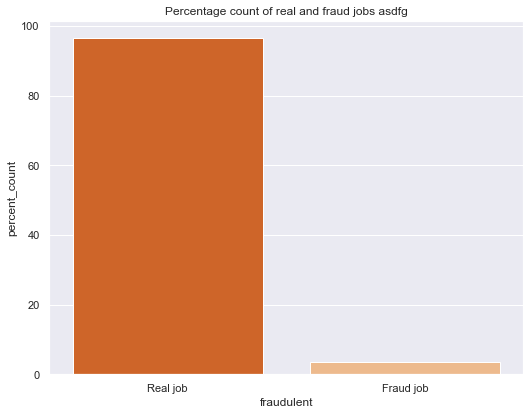

In [39]:
df_plot = pd.read_csv("recruitment_plotting.csv")
df_plotted = df_plot[
    df_plot['function'] == 'Data Analyst'
].groupby('fraudulent').size().reset_index().rename(columns={0: 'count'})
df_plotted['percent_count'] = df_plotted['count'] / df_plotted['count'].sum() * 100

# Plot graph based on user input (function or country, count or percent count)
sns.set(font_scale=1)
plt.figure(figsize=(8.5, 6.5))
ax = sns.barplot(data=df_plotted, x='fraudulent', y='percent_count', palette='Oranges_r')
plt.title('Percentage count of real and fraud jobs' + ' asdfg')
ax.set_xticklabels(['Real job', 'Fraud job'])
plt.show()

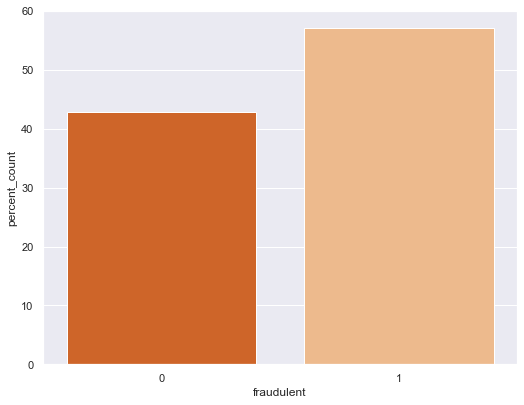

In [36]:
#df_plot = pd.read_csv("recruitment_plotting.csv")
df_plotted = df_plot[
    df_plot['country'] == 'MY'
].groupby('fraudulent').size().reset_index().rename(columns={0: 'count'})
df_plotted['percent_count'] = df_plotted['count'] / df_plotted['count'].sum() * 100

# Plot graph based on user input (function or country, count or percent count)
sns.set(font_scale=1)
plt.figure(figsize=(8.5, 6.5))
sns.barplot(data=df_plotted, x='fraudulent', y='percent_count', palette='Oranges_r')
plt.show()

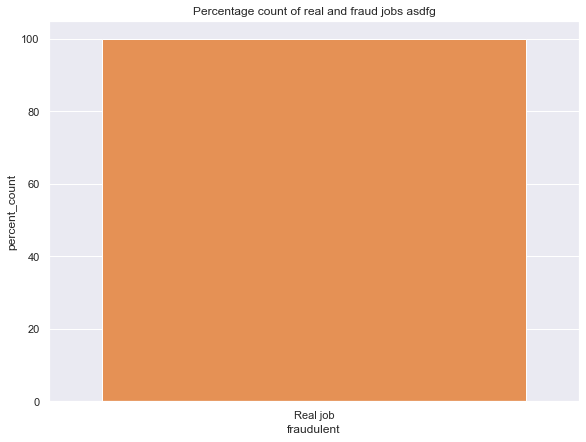

In [107]:
# Plot graph based on user input (function or country, count or percent count)
sns.set(font_scale=1)
plt.figure(figsize=(9.5, 7))
ax = sns.barplot(data=df_plotted2, x='fraudulent', y='percent_count', palette='Oranges_r')
plt.title('Percentage count of real and fraud jobs' + ' asdfg')
if (len(df_plotted2) == 1) & (df_plotted2['fraudulent'][0] == 0):
    ax.set_xticklabels(['Real job'])
elif (len(df_plotted2) == 1) & (df_plotted2['fraudulent'][0] == 1):
    ax.set_xticklabels(['Fraud job'])
elif len(df_plotted2) > 1:
    ax.set_xticklabels(['Real job', 'Fraud job'])
plt.show()

## Part 2: Creating the UI with Gradio

In [109]:
method = gr.inputs.Radio(['Structured data', 'Count vectorizer', 'TFIDF vectorizer'], label="How would you like to predict?")
job_title = gr.inputs.Textbox(placeholder="Enter job title here", label='Job Title')
employment_type = gr.inputs.Radio(['Full-time', 'Part-time', 'Contract', 'Temporary', 'Full-time & Part-time', 'Other'], 
                                     label="Employment Type", default='Full-time')
required_experience = gr.inputs.Dropdown(['Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Executive', 
                                          'Director', 'Not Applicable'], label="Required Experience Category", 
                                         default = 'Entry level')
required_education = gr.inputs.Dropdown([
    "Bachelor's Degree", "Master's Degree", 'High School or equivalent', 'Empty requirements', 'Associate Degree', 
    'Some College Coursework Completed', 'Vocational', 'Certification', 'Doctorate', 'Professional', 
    'Some High School Coursework', 'Vocational - Degree', 'Vocational - HS Diploma', 'Unspecified'
], label="Required Education", default="Bachelor's Degree")
function = gr.inputs.Dropdown(sorted([
    'Marketing', 'Customer Service', 'Administrative', 'Sales', 'Health Care Provider', 'Management', 
    'Information Technology', 'Human Resources', 'Other', 'Engineering', 'Design', 'Education', 'Production', 
    'Supply Chain', 'Business Development', 'Product Management', 'Financial Analyst', 'Consulting', 'Project Management', 
    'Manufacturing', 'Public Relations', 'Writing/Editing', 'Strategy/Planning', 'General Business', 'Advertising', 
    'Finance', 'Research', 'Accounting/Auditing', 'Art/Creative', 'Quality Assurance', 'Training', 'Data Analyst',
    'Business Analyst', 'Distribution', 'Legal', 'Science', 'Purchasing'
]), label="Job Function")
country = gr.inputs.Dropdown(sorted([
    'United States', 'New Zealand', 'Germany', 'Great Britain', 'Australia', 'Singapore', 'Israel', 
    'United Arab Emirates', 'Canada', 'India', 'Egypt', 'Poland', 'Greece', 'Undefined', 'Pakistan', 'Belgium', 'Brazil', 
    'Saudi Arabia', 'Denmark', 'Russia', 'South Africa', 'Cyprus', 'Hong Kong', 'Turkey', 'Ireland', 'Lithuania', 'Japan', 
    'Netherlands', 'Austria', 'South Korea', 'France', 'Estonia', 'Thailand', 'Panama', 'Kenya', 'Mauritius', 'Mexico', 
    'Romania', 'Malaysia', 'Finland', 'China', 'Spain', 'Sweden', 'Chile', 'Ukraine', 'Qatar', 'Italy', 'Latvia', 'Iraq', 
    'Bulgaria', 'Philippines', 'Czech Republic', 'U.S. Virgin Islands', 'Malta', 'Hungary', 'Non-US countries', 
    'Bangladesh', 'Kuwait', 'Luxembourg', 'Nigeria', 'Serbia', 'Belarus', 'Vietnam', 'Indonesia', 'Zambia', 'Norway', 
    'Bahrain', 'Uganda', 'Switzerland', 'U.S. & Other countries', 'Trinidad & Tobago', 'Sudan', 'Slovakia', 'Argentina', 
    'Taiwan', 'Portugal', 'Peru', 'Colombia', 'Iceland', 'Slovenia', 'Morocco', 'Armenia', 'Tunisia', 'Ghana', 'Albania', 
    'Croatia', 'Cameroon', 'El Salvador', 'Nicaragua', 'Sri Lanka', 'Jamaica', 'Kazakhstan', 'Cambodia'
]), label="Country of Job Post", default="United States")
telecommuting = gr.inputs.Radio(['Yes', 'No'], label='Are there any telecommuting options available?')
has_company_logo = gr.inputs.Radio(['Yes', 'No'], label='Does the company have any company logo?')
has_questions = gr.inputs.Radio(['Yes', 'No'], label='Does the job post contain any questions?')
location = gr.inputs.Textbox(placeholder="Enter location here: eg. US, CA, Los Angeles", 
                             label='Location in the form of country, state, city')
company_profile = gr.inputs.Textbox(lines=4, placeholder="Enter company profile here", label='Company Profile (if any)')
job_description = gr.inputs.Textbox(lines=4, placeholder="Enter job description here", label='Full Job Description')
requirements = gr.inputs.Textbox(lines=4, placeholder="Enter job requirements here", label='Full Job Requirements (if any)')
benefits = gr.inputs.Textbox(lines=4, placeholder="Enter job benefits here", label='Benefits of the Job (if any)')
plot_option = gr.inputs.Radio(['function', 'country'], label='Statistical plotting option')

# Output textbox
output_label = gr.outputs.Label(num_top_classes=2, label="Predicted Label")
output_text = gr.outputs.Textbox(label="Output Message")
output_plot = gr.outputs.Image(plot=True, label="Statistical Plot", type='plot')

## Part 3: Call the launch method

In [112]:
io = gr.Interface(predict, [
    method, job_title, employment_type, required_experience, required_education, function, country, telecommuting, 
    has_company_logo, has_questions, location, company_profile, job_description, requirements, benefits, plot_option
], [output_label, output_text, output_plot], verbose=True, theme='default', title="Job Posting Fraud Prediction Web App", 
                  layout = "unaligned",
                  description="""
                  This is a simple web app that helps users to detect if the job posting is real or fraud, please fill up the inputs and enjoy exploring the app!
                  """, 
                  article="""
                  Nowadays, job scams are on the rise due to the advancement of technology and internet. There have been many reported crimes on victims 
                  getting scammed by fake jobs that claimed to offer attractive salaries and bright futures. Thus, in order to counter the issue, we adopt 
                  data science and machine learning to create a web app that enables users to screen job postings and identify potential fraud jobs.
                  
                  Data source: Employment Scam Aegean Dataset (EMSCAD)
                  """)

In [113]:
io.launch(share=True)

Running locally at: http://127.0.0.1:7885/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://28499.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7885/',
 'https://28499.gradio.app')